In [1]:
!pip install pycountry

  Obtaining dependency information for pycountry from https://files.pythonhosted.org/packages/b1/ec/1fb891d8a2660716aadb2143235481d15ed1cbfe3ad669194690b0604492/pycountry-24.6.1-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/6.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.3 MB 660.6 kB/s eta 0:00:10
    --------------------------------------- 0.1/6.3 MB 919.0 kB/s eta 0:00:07
    --------------------------------------- 0.1/6.3 MB 901.1 kB/s eta 0:00:07
   - -------------------------------------- 0.2/6.3 MB 1.3 MB/s eta 0:00:05
   - -------------------------------------- 0.3/6.3 MB 1.4 MB/s eta 0:00:05
   - -------------------------------------- 0.3/6.3 MB 1.1 MB/s eta 0:00:06
   -- ------------------------------------- 0.3/6.3 MB 1.1 MB/s eta 0:00:06
   -- ------------------------------------- 0.5/6.3 MB 1.3 MB/s eta 0:00:05
   --- ------------------------------------ 0.5/6.3 MB 1.3 MB/s eta 0:00:05
   ---- -----------------------------

In [4]:
!pip install mistralai
import os
#from google.colab import userdata

os.environ['MISTRAL_API_KEY'] = "xGjXBaRNMrkjwL1eIxoP8FuYg24lxxcw"
#ad4muhgPGyYTmaP3f6bUZ8xGLC8ElxjM my key
#xGjXBaRNMrkjwL1eIxoP8FuYg24lxxcw pro key

  Obtaining dependency information for mistralai from https://files.pythonhosted.org/packages/60/77/eb7519ddfccb6428ac430129e7b42cc662e710cb719f82c0ffe79ab50859/mistralai-1.7.0-py3-none-any.whl.metadata
  Obtaining dependency information for eval-type-backport>=0.2.0 from https://files.pythonhosted.org/packages/ce/31/55cd413eaccd39125368be33c46de24a1f639f2e12349b0361b4678f3915/eval_type_backport-0.2.2-py3-none-any.whl.metadata
  Obtaining dependency information for httpx>=0.28.1 from https://files.pythonhosted.org/packages/2a/39/e50c7c3a983047577ee07d2a9e53faf5a69493943ec3f6a384bdc792deb2/httpx-0.28.1-py3-none-any.whl.metadata
  Obtaining dependency information for pydantic>=2.10.3 from https://files.pythonhosted.org/packages/b0/1d/407b29780a289868ed696d1616f4aad49d6388e5a77f567dcd2629dcd7b8/pydantic-2.11.3-py3-none-any.whl.metadata
     ---------------------------------------- 0.0/65.2 kB ? eta -:--:--
     ----------------------- -------------- 41.0/65.2 kB 960.0 kB/s eta 0:00:01
   

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.3 requires pydantic<2.0, but you have pydantic 2.11.3 which is incompatible.


In [5]:
from mistralai import Mistral


client = Mistral(api_key=os.environ['MISTRAL_API_KEY'])

In [2]:
import time
from enum import Enum
from pathlib import Path
from pydantic import BaseModel
import base64
import pycountry
from typing import List, Dict
import json  # Ensure we import the json module
from mistralai import DocumentURLChunk, ImageURLChunk, TextChunk


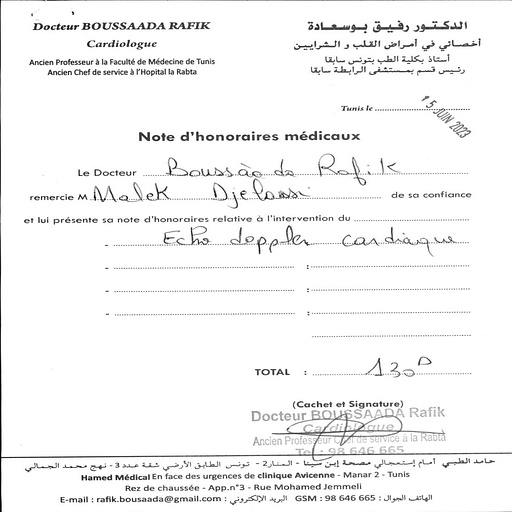

In [7]:
from PIL import Image

image_path = r"C:\Users\EXTRA\Desktop\pi_ds\train_dataset\Processed_Prescriptions\0718--9245013--20230705_page_2.jpg"


image = Image.open(image_path)
image

In [8]:

# Create a dictionary for languages with their alpha_2 code
languages = {lang.alpha_2: lang.name for lang in pycountry.languages if hasattr(lang, 'alpha_2')}

# Meta class for generating language enum values dynamically
class LanguageMeta(Enum.__class__):
    def __new__(metacls, cls, bases, classdict):
        for code, name in languages.items():
            classdict[name.upper().replace(' ', '_')] = name
        return super().__new__(metacls, cls, bases, classdict)

# Language Enum dynamically populated with languages
class Language(Enum, metaclass=LanguageMeta):
    pass

# Define the structure of the OCR response
class StructuredOCR(BaseModel):
    file_name: str
    topics: List[str]
    languages: List[Language]
    ocr_contents: Dict

# Function to print the schema of StructuredOCR
print(StructuredOCR.schema_json())

# Assuming you have some 'client' and methods like 'ImageURLChunk' defined somewhere
# Here's the structured_ocr function
def structured_ocr(image_path: str) -> StructuredOCR:
    image_file = Path(image_path)
    
    # Check if the image file exists
    assert image_file.is_file(), "The provided image path does not exist."

    # Read and encode the image file to base64
    encoded_image = base64.b64encode(image_file.read_bytes()).decode()
    base64_data_url = f"data:image/jpeg;base64,{encoded_image}"

    try:
        # Process the image using OCR
        image_response = client.ocr.process(document=ImageURLChunk(image_url=base64_data_url), model="mistral-ocr-latest")
        
        # Extract the markdown from OCR results
        image_ocr_markdown = image_response.pages[0].markdown

        # Use the chat client to parse the markdown OCR result into structured JSON
        chat_response = client.chat.parse(
            model="pixtral-12b-latest",
            messages=[
                {
                    "role": "user",
                    "content": [
                        ImageURLChunk(image_url=base64_data_url),
                        TextChunk(text=(
                            "This is the image's OCR in markdown:\n"
                            f"<BEGIN_IMAGE_OCR>\n{image_ocr_markdown}\n<END_IMAGE_OCR>.\n"
                            "Convert this into a structured JSON response with the OCR contents in a sensible dictionary."
                        ))
                    ],
                },
            ],
            response_format=StructuredOCR,
            temperature=0
        )
        
        # Return the structured response
        return chat_response.choices[0].message.parsed

    except Exception as e:
        print(f"An error occurred: {e}")
        return None

# Example usage (make sure to provide the correct image path)
image_path = r"C:\Users\EXTRA\Desktop\pi_ds\train_dataset\Processed_Prescriptions\0718--9245013--20230705_page_2.jpg"
structured_data = structured_ocr(image_path)

# Print the structured OCR result
if structured_data:
    # Convert Language enum values to their string names for JSON serialization
    structured_data_dict = structured_data.model_dump()  # This replaces the `json()` method for serialization
    
    # Manually convert the `languages` list from Language enum to strings
    structured_data_dict['languages'] = [lang.name for lang in structured_data_dict['languages']]

    # Convert the dictionary to a JSON string with indentation
    json_string = json.dumps(structured_data_dict, indent=4)
    print(json_string)
else:
    print("OCR processing failed.")



C:\Users\EXTRA\AppData\Local\Temp\ipykernel_6720\117041656.py:23: PydanticDeprecatedSince20: The `schema_json` method is deprecated; use `model_json_schema` and json.dumps instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  print(StructuredOCR.schema_json())


{"$defs": {"Language": {"enum": ["Afar", "Abkhazian", "Afrikaans", "Akan", "Amharic", "Arabic", "Aragonese", "Assamese", "Avaric", "Avestan", "Aymara", "Azerbaijani", "Bashkir", "Bambara", "Belarusian", "Bengali", "Bislama", "Tibetan", "Bosnian", "Breton", "Bulgarian", "Catalan", "Czech", "Chamorro", "Chechen", "Church Slavic", "Chuvash", "Cornish", "Corsican", "Cree", "Welsh", "Danish", "German", "Dhivehi", "Dzongkha", "Modern Greek (1453-)", "English", "Esperanto", "Estonian", "Basque", "Ewe", "Faroese", "Persian", "Fijian", "Finnish", "French", "Western Frisian", "Fulah", "Scottish Gaelic", "Irish", "Galician", "Manx", "Guarani", "Gujarati", "Haitian", "Hausa", "Serbo-Croatian", "Hebrew", "Herero", "Hindi", "Hiri Motu", "Croatian", "Hungarian", "Armenian", "Igbo", "Ido", "Sichuan Yi", "Inuktitut", "Interlingue", "Interlingua (International Auxiliary Language Association)", "Indonesian", "Inupiaq", "Icelandic", "Italian", "Javanese", "Japanese", "Kalaallisut", "Kannada", "Kashmiri", 